In [1]:
from li2021_odeint import change_params, create_fig3, lightsim_20min_5min, params
from matplotlib import pyplot as plt
from matplotlib.lines import Line2D
from mxlpy import Simulator, make_protocol
from mxlpy_version import get_li2021
from tqdm import tqdm

import mxlbricks.names as n


Simulating 'vccn1clce2kea3' in mxlpy: 100%|██████████| 8/8 [00:06<00:00,  1.21it/s]


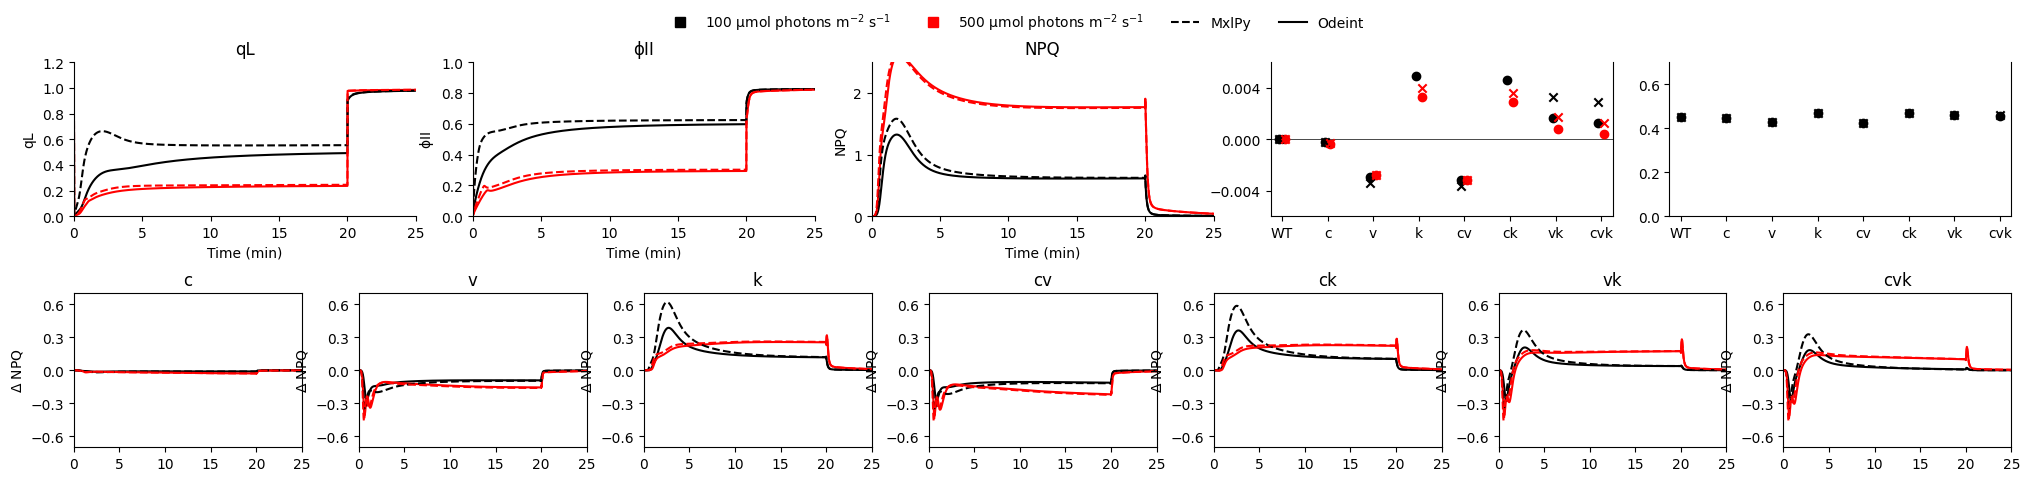

In [2]:
fig3, axs = create_fig3()

light_100 = make_protocol([(20 * 60, {"PAR": 100}), (5 * 60, {"PAR": 0})])
light_500 = make_protocol([(20 * 60, {"PAR": 500}), (5 * 60, {"PAR": 0})])

g_types = ["WT", "clce2", "vccn1", "kea3", "clce2vccn1", "clce2kea3", "vccn1kea3", "vccn1clce2kea3"]

res_mine = {}
for g_type in (pbar := tqdm(g_types)):
    pbar.set_description(f"Simulating '{g_type}' in mxlpy")
    m = get_li2021()
    
    if "clce2" in g_type:
        m.update_parameter("k_CLCE", 0)
    if "vccn1" in g_type:
        m.update_parameter("k_VCCN1", 0)
    if "kea3" in g_type:
        m.update_parameter("k_KEA", 0)
    
    res_mine[g_type] = {}
    
    for par, prtc in zip(["100", "500"], [light_100, light_500]):
        s = Simulator(m)
        s.simulate_protocol(prtc, time_points_per_step=1000)
        variables, fluxes = s.get_result()
        res_mine[g_type][par] = variables

for res, color in zip([res_mine["WT"]["100"], res_mine["WT"]["500"]], ["black", "red"]):
    axs["A"].plot(res.index / 60, 1-res["QA_red"], color=color, ls="dashed")
    axs["B"].plot(res.index / 60, res["Phi2"], color=color, ls="dashed")
    axs["C"].plot(res.index / 60, res["NPQ"], color=color, ls="dashed")

for ax_let, key in zip(list("FGHIJKL"), ["clce2", "vccn1", "kea3", "clce2vccn1", "clce2kea3", "vccn1kea3", "vccn1clce2kea3"]):
    ax = axs[ax_let]
    for par, color in zip(["100", "500"], ["black", "red"]):
        res = res_mine[key][par]
        ax.plot(res.index / 60, res["NPQ"] - res_mine["WT"][par]["NPQ"], color = color, ls="dashed")
        
x_coord = 0
width = 0.125
xcoords = []
for key in ["WT", "clce2", "vccn1", "kea3", "clce2vccn1", "clce2kea3", "vccn1kea3", "vccn1clce2kea3"]:
    axs["D"].scatter(x_coord - width, max(res_mine[key]["100"]["delta_pH_inVolts"]) - max(res_mine["WT"]["100"]["delta_pH_inVolts"]), color="black", marker="x")
    axs["D"].scatter(x_coord + width, max(res_mine[key]["500"]["delta_pH_inVolts"]) - max(res_mine["WT"]["500"]["delta_pH_inVolts"]), color="red", marker="x")
    
    max_Z = max(res_mine[key]["500"][n.zx()])
    max_V = max(res_mine[key]["500"][n.vx()])
    axs["E"].scatter(x_coord, max_Z / (max_Z + max_V), color="black", marker="x")
    xcoords += [x_coord]
    x_coord += 2
    
fig3.legend(
    [
        Line2D([0], [0], color="black", marker="s", markersize=7, ls="None"),
        Line2D([0], [0], color="red", marker="s", markersize=7, ls="None"),
        Line2D([0], [0], color="black", ls="dashed"),
        Line2D([0], [0], color="black", ls="solid")
    ],
    ["100 µmol photons m$^{-2}$ s$^{-1}$", "500 µmol photons m$^{-2}$ s$^{-1}$", "MxlPy", "Odeint"],
    ncols=4,
    frameon=False,
    loc="upper center",
)

plt.show()

Simulating 'vccn1clce2kea3': 100%|██████████| 8/8 [00:01<00:00,  6.46it/s]


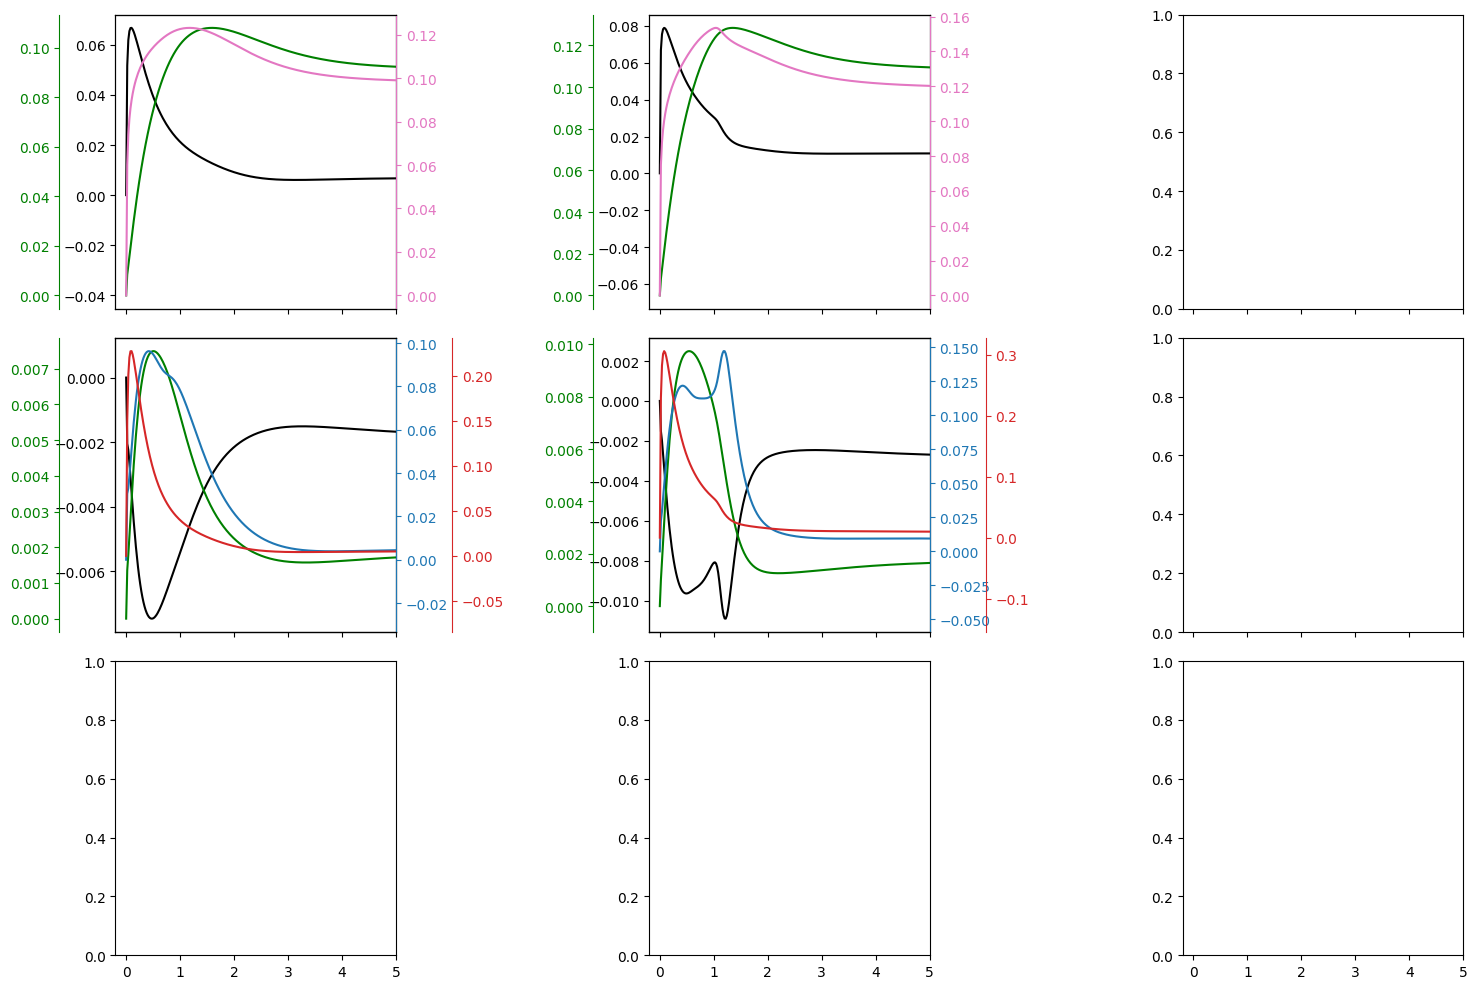

In [3]:
res_fig4 = {}
for g_type in (pbar := tqdm(["WT", "clce2", "vccn1", "kea3", "clce2vccn1", "clce2kea3", "vccn1kea3", "vccn1clce2kea3"])):
    pbar.set_description(f"Simulating '{g_type}'")
    new_pars = change_params(params.copy(), g_type) if g_type != "WT" else params.copy()
    res_fig4[g_type] = {
        "100": lightsim_20min_5min(100, new_pars),
        "500": lightsim_20min_5min(500, new_pars)
    }

fig4, axs = plt.subplot_mosaic([
    ["A", "B", "C"],
    ["D", "E", "F"],
    ["G", "H", "I"]
], figsize=(15, 10), sharex=True)

for ax, par in zip(["A", "B"], ["100", "500"]):
    axs[ax].plot(res_fig4["WT"][par]["time_min"], res_fig4["WT"][par]["Dy"], color="black")
    
    ph_axis = axs[ax].twinx()
    ph_axis.spines["left"].set_position(("axes", -0.2))
    ph_axis.spines["left"].set_visible(True)
    ph_axis.spines["left"].set_color("green")
    ph_axis.yaxis.set_label_position('left')
    ph_axis.yaxis.set_ticks_position('left')
    ph_axis.tick_params(axis='y', colors='green')
    ph_axis.plot(res_fig4["WT"][par]["time_min"], res_fig4["WT"][par]["delta_pH_V"], color="green")
    
    pmf_axis = axs[ax].twinx()
    pmf_axis.spines["right"].set_color("tab:pink")
    pmf_axis.tick_params(axis='y', colors='tab:pink')
    pmf_axis.plot(res_fig4["WT"][par]["time_min"], res_fig4["WT"][par]["pmf"], color="tab:pink")
    
for ax, par in zip(["D", "E"], ["100", "500"]):
    axs[ax].plot(res_fig4["WT"][par]["time_min"], res_fig4["WT"][par]["Dy"] - res_fig4["vccn1"][par]["Dy"], color="black")
    
    ph_axis = axs[ax].twinx()
    ph_axis.spines["left"].set_position(("axes", -0.2))
    ph_axis.spines["left"].set_visible(True)
    ph_axis.spines["left"].set_color("green")
    ph_axis.yaxis.set_label_position('left')
    ph_axis.yaxis.set_ticks_position('left')
    ph_axis.tick_params(axis='y', colors='green')
    ph_axis.plot(res_fig4["WT"][par]["time_min"], res_fig4["WT"][par]["delta_pH_V"] - res_fig4["vccn1"][par]["delta_pH_V"], color="green")
    
    K_axis = axs[ax].twinx()
    K_axis.spines["right"].set_color("tab:blue")
    K_axis.tick_params(axis='y', colors='tab:blue')
    K_axis.plot(res_fig4["WT"][par]["time_min"], (res_fig4["WT"][par]["v_KEA"] - res_fig4["WT"][par]["v_K_channel"]) - (res_fig4["vccn1"][par]["v_KEA"] - res_fig4["vccn1"][par]["v_K_channel"]), color="tab:blue")
    
    Cl_axis = axs[ax].twinx()
    Cl_axis.spines["right"].set_position(("axes", 1.2))
    Cl_axis.spines["right"].set_color("tab:red")
    Cl_axis.tick_params(axis='y', colors='tab:red')
    Cl_axis.plot(res_fig4["WT"][par]["time_min"], (res_fig4["WT"][par]["v_VCCN1"] + res_fig4["WT"][par]["v_CLCE"]) - (res_fig4["vccn1"][par]["v_VCCN1"] + res_fig4["vccn1"][par]["v_CLCE"]), color="tab:red")

for ax in ["A", "B"]:
    axs[ax].set_xlim(-0.2, 5)

plt.tight_layout()

plt.show()

Simulating 'kea3': 100%|██████████| 2/2 [00:00<00:00,  6.38it/s]


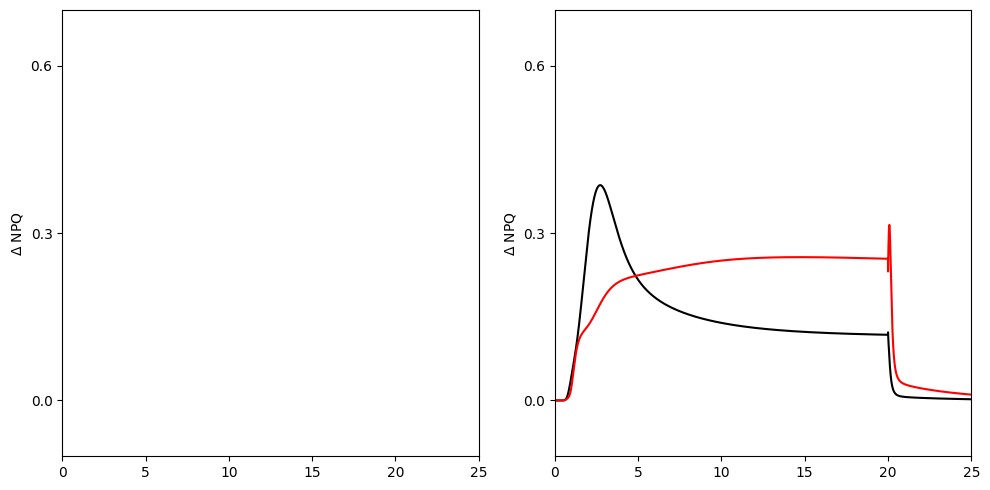

In [4]:
res_fig4_a = {}
for g_type in (pbar := tqdm(["WT", "kea3"])):
    pbar.set_description(f"Simulating '{g_type}'")
    new_pars = change_params(params.copy(), g_type) if g_type != "WT" else params.copy()
    res_fig4_a[g_type] = {
        "100": lightsim_20min_5min(100, new_pars),
        "500": lightsim_20min_5min(500, new_pars)
    }
    
fig4_a, (ax1, ax2) = plt.subplots(ncols=2, figsize=(10, 5))


for par, color in zip(["100", "500"], ["black", "red"]):
    ax2.plot(res_fig4_a["kea3"][par]["time_min"], res_fig4_a["kea3"][par]["NPQ"] - res_fig4_a["WT"][par]["NPQ"], color = color)
    
for ax in (ax1, ax2):
    ax.set_ylim(-0.1, 0.7)
    ax.set_yticks([0, 0.3, 0.6])
    ax.set_ylabel(r"$\Delta$ NPQ")
    ax.set_xlim(0, 25)
    ax.set_xticks([0, 5, 10, 15, 20, 25])
    
plt.tight_layout()